# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 204079453_205714447 ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [4]:
print(training_set.shape)
training_set.head()

(2000, 3)


,x1,x2,y
0,-1.385789,9.131464,0
1,-2.236903,5.561178,0
2,-2.362524,5.215973,0
3,-0.499655,4.981781,0
4,-2.976062,6.236138,0


## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

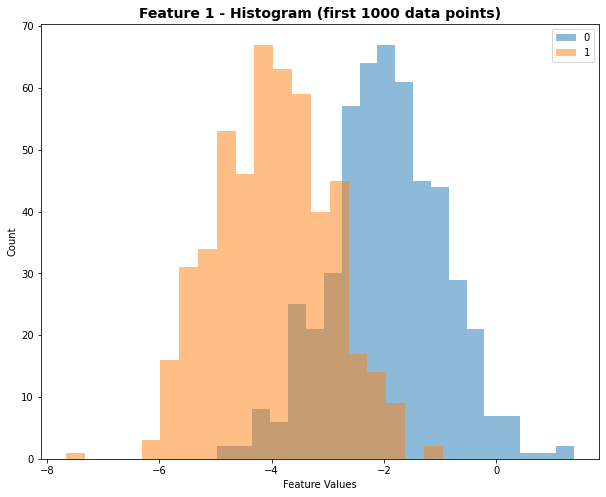

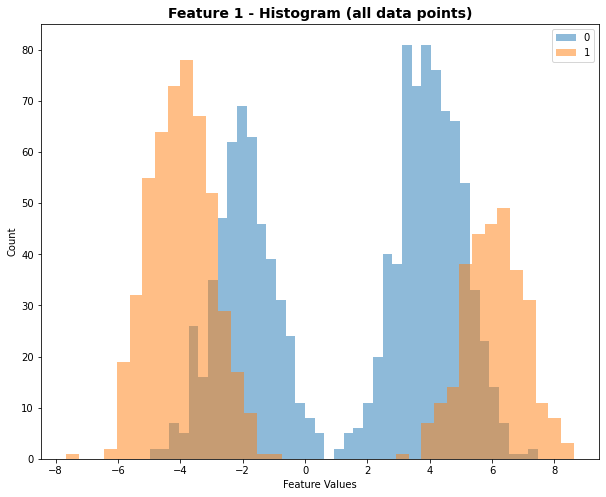

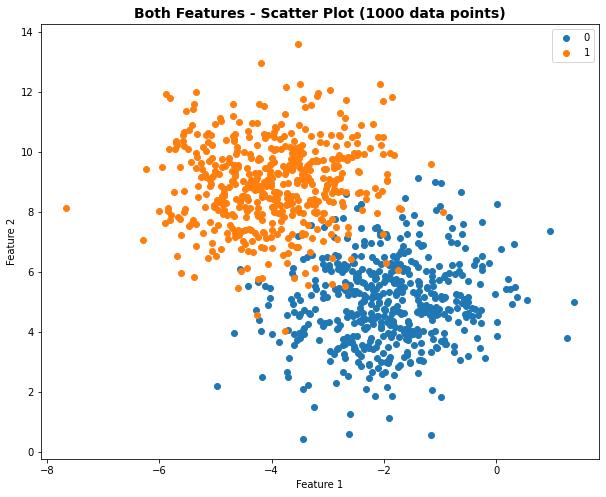

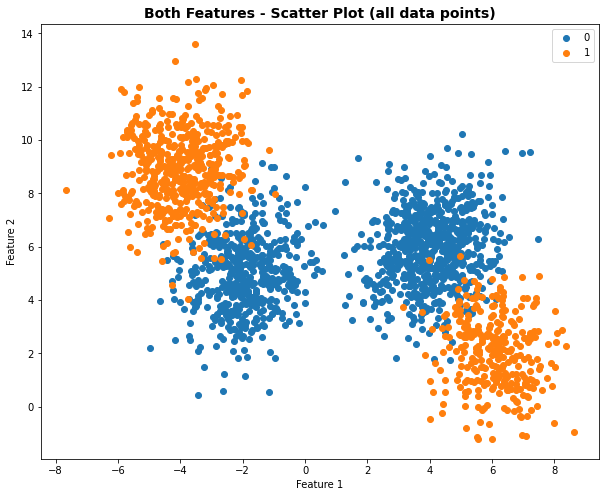

In [5]:
# for first feature only

# 1 - For the first 1000 data points plot a histogram for each class on the same graph
train_1000_samples = training_set[:1000].values
train_1000_samples_y0 = train_1000_samples[train_1000_samples[:,-1]==0]
train_1000_samples_y1 = train_1000_samples[train_1000_samples[:,-1]==1]
plt.hist(train_1000_samples_y0[:,0], bins=20, alpha=0.5, label='0')
plt.hist(train_1000_samples_y1[:,0], bins=20, alpha=0.5, label='1')
plt.title("Feature 1 - Histogram (first 1000 data points)", fontweight='bold', fontsize=14)
plt.xlabel("Feature Values")
plt.ylabel("Count")
plt.legend()
plt.show()

# 2 - For all the data points plot a histogram for each class on the same graph
train_samples = training_set.values
train_samples_y0 = train_samples[train_samples[:,-1]==0]
train_samples_y1 = train_samples[train_samples[:,-1]==1]
plt.hist(train_samples_y0[:,0], bins=40, alpha=0.5, label='0')
plt.hist(train_samples_y1[:,0], bins=40, alpha=0.5, label='1')
plt.title("Feature 1 - Histogram (all data points)", fontweight='bold', fontsize=14)
plt.xlabel("Feature Values")
plt.ylabel("Count")
plt.legend()
plt.show()

# For both features:
# 1- For the first 1000 data points plot a scatter plot where each class has different color
plt.scatter(x = train_1000_samples_y0[:,0], y= train_1000_samples_y0[:,1], label='0')
plt.scatter(x = train_1000_samples_y1[:,0], y= train_1000_samples_y1[:,1], label='1')
plt.title("Both Features - Scatter Plot (1000 data points)", fontweight='bold', fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# 2 - For all the data points plot a scatter plot where each class has different color
plt.scatter(x = train_samples_y0[:,0], y= train_samples_y0[:,1], label='0')
plt.scatter(x = train_samples_y1[:,0], y= train_samples_y1[:,1], label='1')
plt.title("Both Features - Scatter Plot (all data points)", fontweight='bold', fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.J_history = []
        self.theta_vec = None 
        
        np.random.seed(self.random_state)
    
    def compute_cost(self,X,y,theta):
        h_0 = 1/(1+np.exp(-X @ theta.T))
        J = (1/X.shape[0]) * (np.sum(-1*y*np.log(h_0)-(1-y)*np.log(1-h_0)))
        return J
        
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
  
        # bias trick:
        bias = np.ones((X.shape[0],1))
        X = np.hstack((bias, X))
        
        # row vector 
        self.theta_vec = np.random.random(size=X.shape[1])
        
        
        for i in range(self.n_iter):
            h_0 = 1/(1+np.exp(-1*(X @ self.theta_vec.T)))
            grad = (self.eta*(h_0-y))@X
            self.theta_vec = self.theta_vec - grad
            
            J=self.compute_cost(X,y,self.theta_vec)
            self.J_history.append(J)
            
            if (self.J_history[i-1]-J<self.eps) and (i>0):
                break
            
    def predict(self, X):
        """Return the predicted class label"""
        # bias trick:
        bias = np.ones((X.shape[0],1))
        X = np.hstack((bias, X))
        h_0 = 1/(1+np.exp(-1*(X @ self.theta_vec.T)))
        h_0 = np.where(h_0>=0.5,1,0)
        return h_0


In [7]:
def compute_accuracy(testset, classifier):
    
    tp_tn_counter = 0
    
    prediction = classifier.predict(testset[:,:-1])
    for inst, pred in zip(testset, prediction):
        
        if pred == inst[-1]:
            tp_tn_counter +=1
            
    accuracy = tp_tn_counter/len(testset)
    return accuracy

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [8]:
#### Your code here ####

etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

np.random.seed(10)

n_fold = 5
data = training_set.values
np.random.shuffle(data)
split_data_list = np.vsplit(data,n_fold)

best_acc=0
best_eta=0
best_eps=0


for et in etas:
    for ep in epss:
        
        acc_list_per_group = []
        
        for i, fold_data in enumerate(split_data_list):
            
            # Generating the train group:
            k = int(data.shape[0]/n_fold)
            train_data = np.concatenate((data[:k*(i),:], data[k*(i+1):,:]))
            X_train, y_train = train_data[:,:-1], train_data[:,-1]
            
            # generating LogReg object:
            logreg = LogisticRegressionGD(eta=et, eps=ep)
            logreg.fit(X_train,y_train)
            
            # Generating the val gorup:
            val_data = fold_data.copy()
            acc = compute_accuracy(val_data,logreg)
            acc_list_per_group.append(acc)
            
        mean_acc = np.mean(acc_list_per_group)
        
        # Chosing the best acc, ep and eta: 
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_eta = et
            best_eps = ep

In [9]:
print(f"The best accuracy:{best_acc}, was recived with eta: {best_eta} and eps: {best_eps}")

The best accuracy:0.792, was recived with eta: 5e-05 and eps: 1e-06


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [10]:
#### Your code here ####
# calc normal pdf
def norm_pdf(data, mu, sigma):
    norm_pdf = (1 / (sigma * np.sqrt(2 * np.pi)))*np.exp(-0.5*(np.power(((data-mu)/sigma),2)))
    return norm_pdf

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [11]:
# New Version:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01,random_state = 42):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.respons = None
        self.means = []
        self.stds = []
        self.weights = None
        self.J_history = []
        

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        # genrate random numbers in the size of k that sums up to 1
        self.weights = np.random.dirichlet(np.ones(self.k))
        
        # the parameters calculated from the data:
        split_data = np.array_split(data,self.k)
        
        for i in split_data:
            self.means.append(np.mean(i))
            self.stds.append(np.std(i))
        
        #return self.weights, self.means, self.stds

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        r = [] # responsibilities
        p = [] # probabilites
        
        # probabilites calc
        for i in range(self.k):
            p.append(self.weights[i]*norm_pdf(data,self.means[i],self.stds[i]))
        
        total_p = np.sum(p, axis=0) # sum along each instance (rows)
        
        # responsibilities calc
        for i in range(self.k):
             r.append(p[i]/total_p)
        self.respons = r

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        denom = data.shape[0]
        
        # update weights
        for i in range(self.k):
            self.weights[i] = np.sum(self.respons[i])/denom
            
        #update means
        for i in range(self.k):
            self.means[i] = (np.sum(self.respons[i]*data))/(self.weights[i]*denom)
            
        #update stds
        for i in range(self.k):
            var = np.sum(self.respons[i]*((data-self.means[i])**2))/(self.weights[i]*denom)
            self.stds[i] = np.sqrt(var)
            
    
    def compute_cost(self, data):
        """Compute cost"""
        J=0
        for i in range (self.k):
            pdf = norm_pdf(data, self.means[i], self.stds[i])
            log = np.log(self.weights[i]*pdf)
            J += np.sum(-1*log)
        return J

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        
        #iterate until the difference between the previous cost and the current is less than eps or when reach n_iter 
        #find best parameters for the given training set
        for i in range (self.n_iter):
            self.expectation(data)
            self.maximization(data)
            
            J = self.compute_cost(data)                     
            self.J_history.append(J)
            
            if (i>0):
                if ((self.J_history[i-1]-J)<(self.eps)):
                    break

    def get_dist_params(self):
        return self.weights, self.means, self.stds
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [12]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.label = []
        self.prior = []
        self.dist_params = {}
        
        for label in range(len(np.unique(y))):
            self.label.append(label)
            self.dist_params[label] = {}
            labeled_feature = X[y == label]
            self.prior.append(labeled_feature.shape[0] / X.shape[0])
            for feature in np.arange(X.shape[1]):
                feature_label = labeled_feature[:,feature]
                em_params = EM(k = self.k)
                em_params.fit(feature_label)
                self.dist_params[label][feature] = [em_params.get_dist_params()[0], 
                                                    em_params.get_dist_params()[1], 
                                                    em_params.get_dist_params()[2]]  


    def predict(self, X):
        """Return the predicted class label"""
        
        likelihood_per_class = []
        
        for label in self.dist_params.keys():
            likelihood_per_feature = 1
            for feature in self.dist_params[label].keys():
                likelihood = 0
                weights = self.dist_params[label][feature][0]
                means = self.dist_params[label][feature][1]
                stds = self.dist_params[label][feature][2]
                feature_data = X[:,feature]
                for k in range(self.k):
                    if self.k == 1:
                        likelihood += (weights * norm_pdf(feature_data, means, stds))
                    else:
                        likelihood += (weights[k] * norm_pdf(feature_data, means[k], stds[k]))
                likelihood_per_feature *= likelihood
            likelihood_per_class.append(likelihood_per_feature)
        likelihood_per_class *= np.array(self.prior).reshape(-1,1)
        pred = (likelihood_per_class[1] > likelihood_per_class[0]) * 1
        return pred


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [40]:
# 1:
# Extracting the first 1000 points from the train set:
train_first_1000 = training_set[:1000].values

# Split into X and y:
X_train_first_1000 = train_first_1000[:,:-1]
y_train_first_1000 = train_first_1000[:,-1]

# Extracting the first 500 points from the test set:
test_first_500 = test_set[:500].values

# Split into X and y:
X_test_first_500 = test_first_500[:,:-1]
y_test_first_500 = test_first_500[:,-1]

In [41]:
# 2:
# fitting the Logistic Regression (GD) model with best params:
logreg = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logreg.fit(X_train_first_1000,y_train_first_1000)

# 4: 
# Accuracies printing: 
print("Logistic Regression (GD):")
print(f"Train accuracy: {compute_accuracy(train_first_1000,logreg)}")
print(f"Test accuracy: {compute_accuracy(test_first_500,logreg)}")

Logistic Regression (GD):
Train accuracy: 0.965
Test accuracy: 0.938


In [42]:
# 3:
# fitting the NaiveBayesGaussian model with best params:
############ YUVAL - NEED TO CHOSE THE BEST K (1 is not correct)#################
nb = NaiveBayesGaussian(k=2) ###### Change the K after completing the naive bayes class. 
nb.fit(X_train_first_1000,y_train_first_1000)

# 4: 
# Accuracies printing: 
print("Naive Bayes:")
print(f"Train accuracy: {compute_accuracy(train_first_1000,nb)}")
print(f"Test accuracy: {compute_accuracy(test_first_500,nb)}")

Naive Bayes:
Train accuracy: 0.966
Test accuracy: 0.942


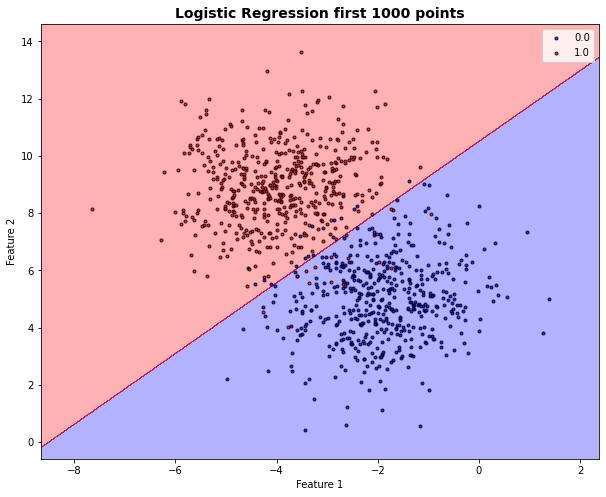

In [43]:
plot_decision_regions(X_train_first_1000, y_train_first_1000, logreg)
plt.title('Logistic Regression first 1000 points', fontweight='bold', fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

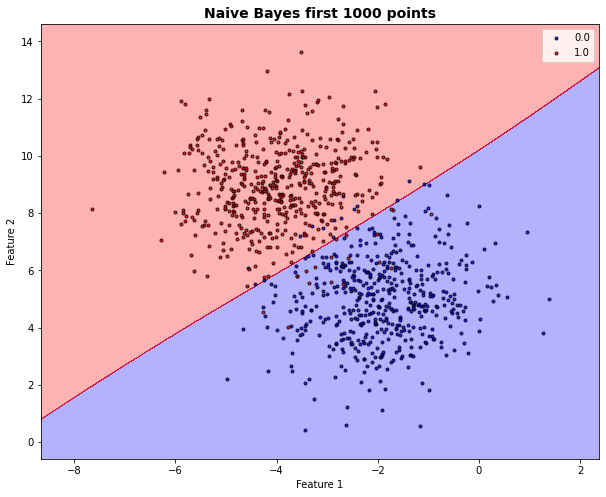

In [44]:
# y_train_first_1000.astype(np.integer)
plot_decision_regions(X_train_first_1000, y_train_first_1000, nb)
plt.title('Naive Bayes first 1000 points', fontweight='bold', fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

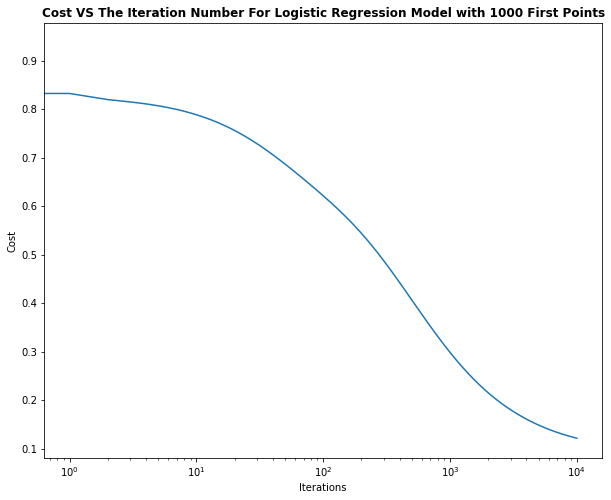

In [45]:
plt.plot(np.arange(logreg.n_iter), logreg.J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost VS The Iteration Number For Logistic Regression Model with 1000 First Points', fontweight='bold', fontsize=12)
plt.show()

<b>First 1000 points:</b>
<br>For both LRGD and Naive Bayes, the accuracy is fairly high.
<br>In the data exploration section, the scatter plot shows that the data is almost linearly separable, which is consistent with the plot above and the accuracy result. 

In [46]:
# Train - Split into X and y:
train_all = training_set.values
X_train_all = train_all[:,:-1]
y_train_all = train_all[:,-1]

# Test - Split into X and y:
test_all = test_set.values
X_test_all = test_all[:,:-1]
y_test_all = test_all[:,-1]

In [47]:
# 2:
# fitting the Logistic Regression (GD) model with best params:
logreg_all = LogisticRegressionGD(eta=best_eta, eps=best_eps)
logreg_all.fit(X_train_all,y_train_all)

# Accuracies printing: 
print("Logistic Regression (GD)")
print(f"Train accuracy: {compute_accuracy(train_all,logreg_all)}")
print(f"Test accuracy: {compute_accuracy(test_all,logreg_all)}")

Logistic Regression (GD)
Train accuracy: 0.809
Test accuracy: 0.804


In [60]:
# 3:
nb_all = NaiveBayesGaussian(k=2) 
nb_all.fit(X_train_all,y_train_all)

# 4: 
# Accuracies printing: 
print("Naive Bayes")
print(f"Train accuracy: {compute_accuracy(train_all,nb_all)}")
print(f"Test accuracy: {compute_accuracy(test_all,nb_all)}")

Naive Bayes
Train accuracy: 0.919
Test accuracy: 0.899


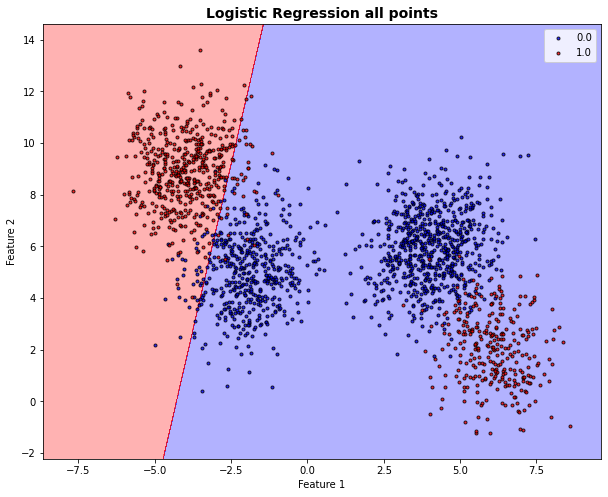

In [61]:
plot_decision_regions(X_train_all, y_train_all, logreg_all)
plt.title('Logistic Regression all points', fontweight='bold', fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

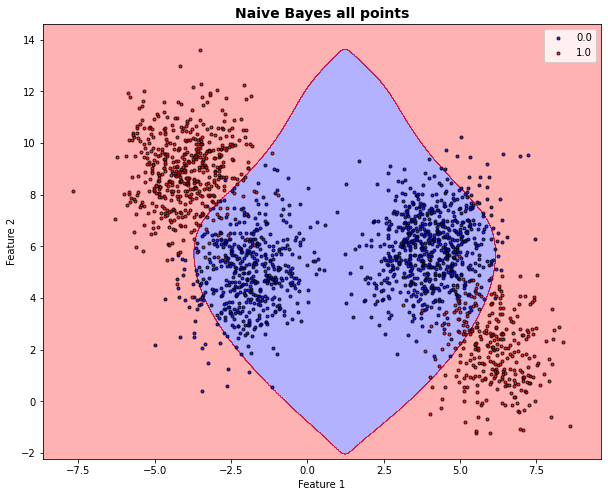

In [62]:
# y_train_first_1000.astype(np.integer)
plot_decision_regions(X_train_all, y_train_all, nb_all)
plt.title('Naive Bayes all points', fontweight='bold', fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

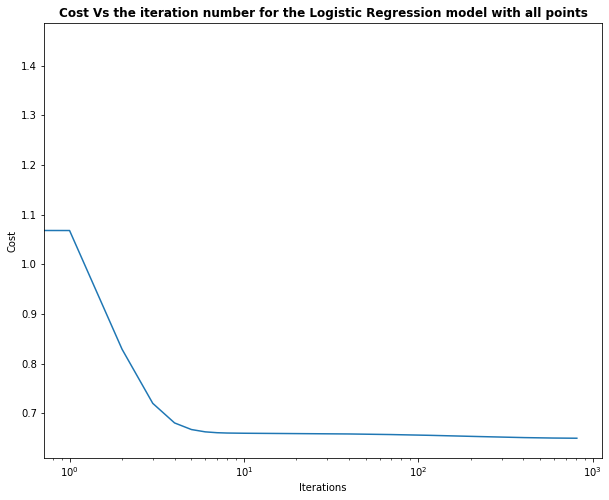

In [63]:
plt.plot(np.arange(len(logreg_all.J_history)), logreg_all.J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Vs the iteration number for the Logistic Regression model with all points', fontweight='bold', fontsize=12)
plt.show()

<b>All points:</b>
<br>Naive Bayes yielded a better result than LRGD.
<br>The LRGD didn't yield good results, because, on the given feature spaces, it cannot linearly separate the data into two classes.
<br>However, naiveBayes with EM succeeded in handling data from multiple distributions. Based on the data exploration section, it appears that each class originated from two different Gaussian mixtures (the reason why we chose k=2).

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


In [64]:
from scipy.stats import multivariate_normal

In [65]:
# 1- generate a dataset

size = [800, 500, 800]
means = [[1, 1, 1], [5, 5, 5], [10, 10, 10]]
cov = [[1, 1, 1],[1, 1, 1], [1, 1, 1]]


x1 =[]
x2 =[]
x3 = []

# inital label:
y=[]

for i in range(3):
#     x_1 = np.random.multivariate_normal(means[i], cov, size[i])[:,0]
#     x_2 = np.random.multivariate_normal(means[i], cov, size[i])[:,1]
#     x_3 = np.random.multivariate_normal(means[i], cov, size[i])[:,2]
    x_1, x_2, x_3 =np.random.multivariate_normal(means[i], cov, size[i]).T
    
    x1.extend(x_1)
    x2.extend(x_2)
    x3.extend(x_3)
    
    # to think- 
    y.extend([i%2]*size[i])

x1 = np.array(x1).reshape(-1, 1)
x2 = np.array(x2).reshape(-1, 1)
x3 = np.array(x3).reshape(-1, 1)
X_train = np.hstack((x1, x2, x3))
y_train = np.array(y)

train_set = np.hstack((X_train, y_train.reshape(-1, 1)))

nb = NaiveBayesGaussian(k=3)
nb.fit(X_train, y_train)

logreg = LogisticRegressionGD(eta=best_eta, eps=best_eps)    
logreg.fit(X_train, y_train)

In [66]:
compute_accuracy(train_set, nb)

0.9828571428571429

In [67]:
compute_accuracy(train_set, logreg)

0.540952380952381

In [68]:
# 2- generate a dataset

size = [1000, 1000, 1000, 1000]
means = [[5, 5, 5], [5, 5, 5], [5, 5, 5]]
cov = [[[1, -1, -1],[-1, 1, 1], [-1, 1, 1]],
       [[1, -1, -1],[-1, 1, 1], [-1, 1, 1]],
      [[1, 1, 1],[1, 1, 1], [1, 1, 1]]]

x1 =[]
x2 =[]
x3 = []

# inital label:
y=[]

for i in range(3):
#     x_1 = np.random.multivariate_normal(means[i], cov, size[i])[:,0]
#     x_2 = np.random.multivariate_normal(means[i], cov, size[i])[:,1]
#     x_3 = np.random.multivariate_normal(means[i], cov, size[i])[:,2]
    x_1, x_2, x_3 =np.random.multivariate_normal(means[i], cov[i], size[i]).T
    
    x1.extend(x_1)
    x2.extend(x_2)
    x3.extend(x_3)
    
    # to think- 
    y.extend([i%2]*size[i])

x1 = np.array(x1).reshape(-1, 1)
x2 = np.array(x2).reshape(-1, 1)
x3 = np.array(x3).reshape(-1, 1)
X_train = np.hstack((x1, x2, x3))
y_train = np.array(y)

train_set = np.hstack((X_train, y_train.reshape(-1, 1)))

nb = NaiveBayesGaussian(k=3)
nb.fit(X_train, y_train)

logreg = LogisticRegressionGD(eta=best_eta, eps=best_eps)    
logreg.fit(X_train, y_train)

In [69]:
compute_accuracy(train_set, nb)

0.6666666666666666

In [70]:
compute_accuracy(train_set, logreg)

0.6686666666666666

In [71]:
#### Your code here ####
def histogram_visualization(data_0, data_1, bins, alpha, title):
    plt.hist(data_0, bins=bins, alpha=alpha, label='y=0')
    plt.hist(data_1, bins=bins, alpha=alpha, label='y=1')
    plt.legend()
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    
def scatter_visualization(data_0, data_1, title):
    plt.scatter(data_0[:, 0], data_0[:, 2], label='y=0')
    plt.scatter(data_1[:, 0], data_1[:, 2], label='y=1')
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

In [72]:
train_set_nb_better_0 = train_set[train_set[:, -1] == 0]
train_set_nb_better_1 = train_set[train_set[:, -1] == 1]
X_bn_better_set = train_set[:, :-1]
y_bn_better_set = train_set[:, -1]

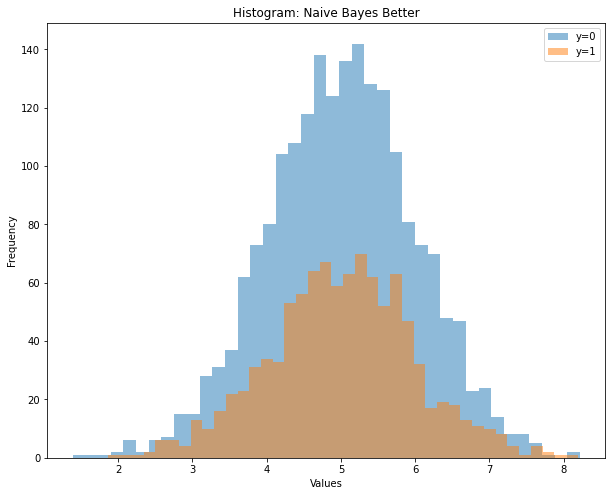

In [73]:
histogram_visualization(train_set_nb_better_0[:, 0], train_set_nb_better_1[:, 0],
              bins=40, alpha=0.5, title='Histogram: Naive Bayes Better')

In [74]:
def generate_datasets(means:list,cov:list,size:list):
    
    # initial features:
    x1 =[]
    x2 =[]
    x3 = []
    
    # inital label:
    y=[]

    for i in range(3):
        
        x_1, x_2, x_3 =np.random.multivariate_normal(means[i], cov, size[i]).T
        
        x1.extend(x_1)
        x2.extend(x_2)
        x3.extend(x_3)
        
        # to think- 
        y.extend([i%2]*size[i])

    x1 = np.array(x1).reshape(-1,1)
    x2 = np.array(x2).reshape(-1,1)
    x3 = np.array(x3).reshape(-1,1)
    X_train = np.hstack((x1, x2, x3))
    y_train = np.array(y)

    train_set = np.hstack((X_train, y_train.reshape(-1, 1)))

    nb = NaiveBayesGaussian(k=3)
    nb.fit(X_train, y_train)

    logreg = LogisticRegressionGD(eta=best_eta, eps=best_eps)    
    logreg.fit(X_train, y_train)

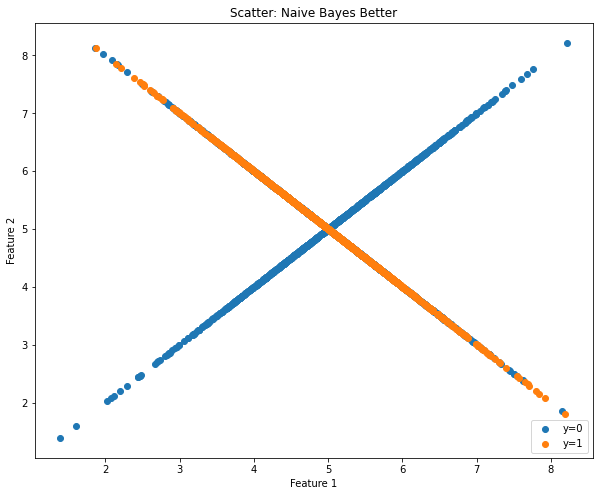

In [75]:
scatter_visualization(train_set_nb_better_0[:, :-1], train_set_nb_better_1[:, :-1],
                      title='Scatter: Naive Bayes Better')